## Exploratory Analysis of a Health Insurance --> Vehicle Insurance dataset

### Problem Statement

Our client is an Insurance company that has provided Health Insurance to its customers now they need our help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

### Goal

Our goal with this analysis is to predict whether or not a customer is interested in Vehicle Insurance given that they already have Health Insurance.

### First let's start with the imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

import shap
import seaborn as sns

### Import the dataset

Now we import the dataset that we will be analysing from https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv

In [2]:
df = pd.read_csv("insurance.csv")
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


### Distribution of Target Variable: Response

We see from this plot that the dataset is heavily unbalanced in favour of `Response = 0` or a customer being "Not interested" in Vehicle Insurance.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Response', ylabel='count'>

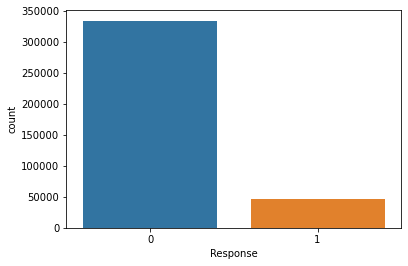

In [3]:
sns.countplot(df.Response)

### Split the data

Unfortunately, since the full dataset was not provided by the creator, we will have to make do by considering the training data to be the full dataset. We can now perform a `train_test_split` to split the data into training data which is what we will be using and test data which will be used to score our models. The `random_state` parameter will be used across all models so that we can maintain uniform randomness. 

In [4]:
df_train, df_test = train_test_split(df, random_state=123)


### Preprocessing Pipeline

We define a function that will perform preprocessing on all the features we pass through. This function will return the encoded features along with `y_train`, `y_test`, and the preprocessor.

In [5]:
def preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features):

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    preprocessor.fit(df_train);

    ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names(categorical_features))
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train).toarray(), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test).toarray(),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train["Response"]
    y_test  = df_test["Response"]
    
    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

### Seperate Features

Here we seperate all the features (columns) in the dataset into 3 different types: Numeric, Categorical, and Drop. 

The `numeric_features` consist only of features that are seen to have a large array of different numeric values such as `Age` and `Vintage`. We choose not to use something like `Previously_Insured` as although it is numeric because it only consists of 0's or 1's, we can perform `OneHotEncoding` to better encode it. We cannot do this for `Annual_Premium` for example as `OneHotEncoding` creates a new column for each unique category value. If we tried this for `Annual_Premium` whose category values are almost all unique, we would have too many columns.

The `drop_features` consist of `id` and `Response`. `id` is removed as it will have no significance on any results and `Response` is removed because it is our target (what we are trying to predict).

The `categorical_features` consist of everything else. It includes any text-based features and binary features. 

Side Note: Although not important in our dataset, in one with a _description_ or _summary_ which consist of multiple texts (sentences), we would employ something like `CountVectorizer` or `TfidfVectorizer` to preprocess those features.

In [6]:
numeric_features = ['Age', 'Annual_Premium', 'Vintage']
categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
drop_features = ['id', 'Response']

Next we create our encoded train and test sets, along with the `y_train`, `y_test`, and preprocessor

In [7]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features)

### Isolation Forest

We will use an IsolationForest for outlier detection. Ideally, our dataset should have little to no outliers so that we do not need to modify the raw data any further. As it turns out, IsolationForest detected 0 outliers in our data which is really good. Outliers are infamous for skewing the results of many scoring methods such as $R^2$ so it is important to remove any that we encounter. Outliers are very difficult to accurately predict and as such many models and scoring techniques are not robust enough to fully handle all types of outliers therefore, removing an outlier makes a bigger impact on your results than striving to maintain a large dataset. 

In [8]:
isolation = IsolationForest(random_state=123)
predicted_outliers = isolation.fit_predict(X_train_enc)
predicted_outliers = predicted_outliers < 0
X_train_enc[predicted_outliers]

,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0



Now we will score the train and test sets on a few classification models

### Scoring on DummyClassifier

Our first classifier will be DummyClassifier. As the name suggests, this classifier works by finding the most common value in the set we pass through and _always_ predicts that. So given an balanced dataset, DummyClassifier will return a score of whatever the split percentage is for each value in the set. In our case, since we are predicting the `Response` feature, _if_ the dataset was balanced (50% `Response` = 1 and 50% `Response` = 0) then DummyClassifier would return 0.5. Since there is no real complexity behind how DummyClassifier functions, it is used more as a baseline rather than a real deployable model. 

In [9]:
# try DummyClassifier

dc = DummyClassifier(strategy='stratified', random_state=123)
dc.fit(df_train, y_train)
dc_trscore = dc.score(df_train, y_train)

In [10]:
dc_tescore = dc.score(df_test, y_test)

### Scoring on LogisticRegression

LogisticRegression is a more complex model used in classification problems such as ours. It is considered a very common model similar to DummyClassifier, but _can_ be used in deployment. Without delving into the math too much, LogisticRegression is a classification model in which input values are linearly combined using weights or coefficient values into a logistic regression equation. Unlike numeric prediction models like Linear Regression, LogisticRegression returns a binary value. This is why earlier, when defining the preprocessing pipeline, we used `OneHotEncoder` as that would turn any categorical feature into a numeric column with only 1s and 0s thus making it interpretable for LogisticRegression.

In [11]:
# try LogisticRegression

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))
lr_pipe.fit(df_train, y_train)
lr_trscore = lr_pipe.score(df_train, y_train)

In [12]:
lr_tescore = lr_pipe.score(df_test, y_test)

### Scoring on LGBMClassifier

LGBMClassifier or more simply LightGBM works based on the Gradient Boosting algorithm. Unlike Adaptive Boosting (AdaBoost), Gradient Boosting will train weak learners by minimizing the loss function of a learner. Essentially it is training on the residuals of the model. Weak learners are usually larger decision tress whereas with AdaBoost they are stumps. All weak learners in Gradient Boosting have equal weightage making the final prediction equally dependent on all of the weak learners. What makes LightGBM a good choice comes from its speed in computation given that it performs Leaf-wise tree growth which splits the decision tree by the leaf with the best fit. Compared to another popular Gradient Boosting algorithm XGBoost which performs Level-wise tree growth which splits a decision tree level or depth wise.

In [13]:
# try LGBMClassifier

lgbm_pipe = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
lgbm_pipe.fit(df_train, y_train)
lgbm_trscore = lgbm_pipe.score(df_train, y_train)

In [14]:
lgbm_tescore = lgbm_pipe.score(df_test, y_test)

### Scoring on AdaBoostClassifier

There are 3 main ideas behind AdaBoost (Adaptive Boost):
1. AdaBoost combines small 1-node 2-leaf trees called _stumps_ to make classifications
2. Some stumps are weighed more in the classification than others
3. Each stump is made by accounting for the previous stumps mistakes

From these ideas, we can see that AdaBoost is somewhat similar to a RandomForest. We choose to use AdaBoostClassifier over something like RandomForestClassifier or DecisionTreeClassifier. Although a RandomForest is more stable (less susceptible to perturbations in the data) making it more difficult to overfit, the computation time was too long. The speed comes from the fact that AdaBoost has a predetermined max depth of 1 for each tree whereas a RandomForest does not. This is the case because AdaBoost often iterates multiple times (100+) to guarantee the "weak learners" or stumps becomes "strong learners" before the final model. There are a few more fundamental differences between RandomForest and AdaBoost in terms of the mathematical approaches each one takes, but we will choose speed given by AdaBoost over a slight increase in the resulting accuracy given by RandomForest. One final note is that the efficiency of AdaBoost is heavily affected by outliers as such, to counteract this, we chose to impute incoming data through our preprocessor. Below is a flowchart roughly of how AdaBoost works.

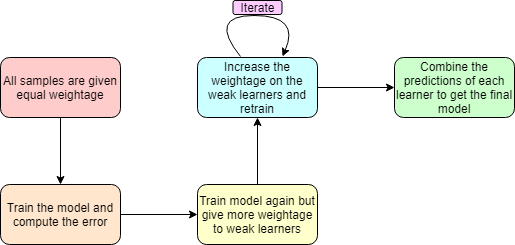

In [15]:
# try AdaBoostClassifier

ada_pipe = make_pipeline(preprocessor, AdaBoostClassifier(random_state=123))
ada_pipe.fit(df_train, y_train)
ada_trscore = ada_pipe.score(df_train, y_train)

In [16]:
ada_tescore = ada_pipe.score(df_test, y_test)

### Compare Train and Test Scores

We see from the table below that the LightGBM Classifier gets the highest test score whereas the Dummy Classifier gets the lowest scores (as it should). A higher test score indicates how much better the model has generalized the data. Since there is no significant difference between the training score and test score, it is likely that none of the models overfit the data. We will still perform cross-validation and hyperparameter tuning as it may change which classifier we should consider using in deployment. 

In [17]:
score_summary = pd.DataFrame([dc_trscore, lr_trscore, lgbm_trscore, ada_trscore], index=[
    "Dummy Classifier",
    "Logistic Regression",
    "LightGBM Classifier", 
    "AdaBoost Classifier"])

score_summary['Test Score'] = [dc_tescore, lr_tescore, lgbm_tescore, ada_tescore]
score_summary.columns = ['Train Score', 'Test Score']
score_summary = score_summary.sort_values(by=['Test Score'], ascending=False)
score_summary


,Train Score,Test Score
LightGBM Classifier,0.877519,0.878073
Logistic Regression,0.876882,0.877915
AdaBoost Classifier,0.876927,0.877873
Dummy Classifier,0.785265,0.787139


### Cross-Validation

Cross-validation is used to test the generalizability of a given model. It is used to access the predictive performance of our models and judge how they perform on a test set. The primary motive for using cross-validation is trying to reduce any overfitting that occurs when we train on our training data. The type of cross-validation we use is called k-Fold Cross-Validation. 

Cross-validation does have some limitations such as when we have implicit bias in our data or when we are using _past_ data to predict _future_ data (our data is time dependent). However, since ideally our dataset has no noticible bias and we know it is not time dependent, we can use cross-validation and get pretty accurate results.

We will perform cross-validation over 5 folds on each of our classifiers. For interpretability, we will also take the mean of each of the 5 folds giving ourselves 1 value per category for each classifier.

In [18]:
#try DummyClassifier
dc_results = pd.DataFrame(cross_validate(dc, df_train, y_train, return_train_score=True)).mean()

# try LogisticRegression
lr_results = pd.DataFrame(cross_validate(lr_pipe, df_train, y_train, return_train_score=True)).mean()

# try LGBMClassifier
lgbm_results = pd.DataFrame(cross_validate(lgbm_pipe, df_train, y_train, return_train_score=True)).mean()

# try AdaBoostClassifier
ada_results = pd.DataFrame(cross_validate(ada_pipe, df_train, y_train, return_train_score=True)).mean()

### Compare Cross-Validation Results

Although in the previous part we recognized that there is _likely_ no overfitting that occurs, we see that LightGBM is no longer the model with the highest test score. Cross-validation works under a k-Folds algorithm which consists of randomizing and spliting the dataset into k groups. This is different than doing a `train_test_split` and scoring on that. This could be one of the reasons that AdaBoost Classifier received a higher test score than LightGBM.

In [19]:
# combine the results of cross-validation of all the classifiers

cv_summary = pd.DataFrame([dc_results, lr_results, lgbm_results, ada_results], index=[
    "Dummy Classifier",
    "Logistic Regression",
    "LightGBM Classifier", 
    "AdaBoost Classifier"])

cv_summary = cv_summary.sort_values(by=["test_score"], ascending=False)
cv_summary

,fit_time,score_time,test_score,train_score
AdaBoost Classifier,7.807373,0.399638,0.877004,0.877052
LightGBM Classifier,1.335511,0.186041,0.876871,0.877522
Logistic Regression,11.490300,0.110871,0.876864,0.876903
Dummy Classifier,0.025023,0.004404,0.785559,0.785138


### Hyperparameter Tuning 

Now we will perform hyperparameter tuning on our classifiers using GridSearchCV. 

In [20]:
# try LogisticRegression

param_grid = {
"logisticregression__C":[0.001,0.01, 1, 10, 100, 1000,10000],
"logisticregression__class_weight":['None' or 'balanced']
}

grid_search = GridSearchCV(lr_pipe, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(df_train, y_train)

lr_trscore = grid_search.score(df_train, y_train)
lr_tescore = grid_search.score(df_test, y_test)

grid_search.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:  1.8min remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.1min finished


{'logisticregression__C': 0.001, 'logisticregression__class_weight': 'None'}

In [21]:
# try LGBMClassifier

param_grid = {
"lgbmclassifier__class_weight":['balanced' or 'None'],
"lgbmclassifier__num_leaves":[31, 127]
}

grid_search = GridSearchCV(lgbm_pipe, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(df_train, y_train)

lgbm_trscore = grid_search.score(df_train, y_train)
lgbm_tescore = grid_search.score(df_test, y_test)

grid_search.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.1s finished


{'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__num_leaves': 127}

In [22]:
# try AdaBoostClassifier

param_grid = {
"adaboostclassifier__algorithm":['SAMME' or 'SAMME.R']
}

grid_search = GridSearchCV(ada_pipe, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(df_train, y_train)

ada_trscore = grid_search.score(df_train, y_train)
ada_tescore = grid_search.score(df_test, y_test)

grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


{'adaboostclassifier__algorithm': 'SAMME'}

In [23]:
tunedscore_summary = pd.DataFrame([dc_trscore, lr_trscore, lgbm_trscore, ada_trscore], index=[
    "Dummy Classifier",
    "Logistic Regression",
    "LightGBM Classifier", 
    "AdaBoost Classifier"])

tunedscore_summary['Test Score tuned'] = [dc_tescore, lr_tescore, lgbm_tescore, ada_tescore]
tunedscore_summary.columns = ['Train Score tuned', 'Test Score tuned']
tunedscore_summary = tunedscore_summary.sort_values(by=["Test Score tuned"], ascending=False)
tunedscore_summary

,Train Score tuned,Test Score tuned
Logistic Regression,0.877204,0.878125
AdaBoost Classifier,0.877207,0.878125
Dummy Classifier,0.785265,0.787139
LightGBM Classifier,0.724673,0.713617


### Compare Tuned and Un-tuned Cross-Validation Results

In our tuned test score, Logistic Regression performed the best. Whereas using cross-validation, AdaBoost Classifier performed the best. We will however consider the results given after tuning hyperparameters to be our final most conclusive results. Thus making Logistic Regression the best classifier (of the ones we chose) to use in deployment. 

In [24]:
final_summary = pd.concat([tunedscore_summary,cv_summary], axis=1).sort_values(by="Test Score tuned", ascending=False)
final_summary = final_summary.drop(columns=['fit_time', 'score_time'])
final_summary

,Train Score tuned,Test Score tuned,test_score,train_score
Logistic Regression,0.877204,0.878125,0.876864,0.876903
AdaBoost Classifier,0.877207,0.878125,0.877004,0.877052
Dummy Classifier,0.785265,0.787139,0.785559,0.785138
LightGBM Classifier,0.724673,0.713617,0.876871,0.877522


### Confusion Matrix

A confusion matrix is really useful when we have two or more classes in a classification problem. Our dataset has the churn or `Response` of a customer which can either be 0 or 1 making a confusion matrix a really good tool in our analysis. From our classification report and confusion matrix, we get an F1-score of 93% and an accuracy of the F1-score to be 88% meaning that our F1-score is 88% accurate which is pretty good. Since the F1-score is the weighted average of the precision and recall, the closer the F1-score is to 1, the better.  

                precision    recall  f1-score   support

Not Interested       0.88      1.00      0.93     83666
    Interested       0.38      0.00      0.01     11612

      accuracy                           0.88     95278
     macro avg       0.63      0.50      0.47     95278
  weighted avg       0.82      0.88      0.82     95278



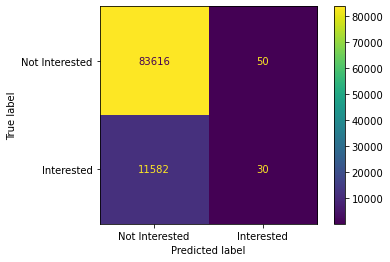

In [25]:
# since LogisticRegression and AdaBoostingClassifier get very similar tuned test scores, we will choose just LogisticRegerssion 
# for further analysis

plot_confusion_matrix(lr_pipe, df_test, y_test, display_labels=["Not Interested", "Interested"])
print(classification_report(y_test, lr_pipe.predict(df_test), target_names=("Not Interested", "Interested")))

### AUC-ROC Curve

ROC is a probability curve in which we find the AUC or area-under-cruve. The AUC represents the measure of seperability or how much our model is capable of distinguishing between classes. Therefore, the higher the AUC the better our model is at distinguishing between customers who are interested and those who are not interested (`Response`). We get an AUC Score of about 0.85 which is pretty good.

AUC Score 0.8491049004506288


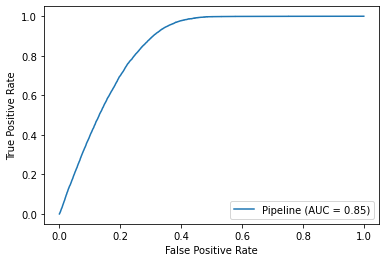

In [26]:
plot_roc_curve(lr_pipe, df_test, y_test)
print("AUC Score", roc_auc_score(y_test, lr_pipe.predict_proba(df_test)[:,1]))

### Feature Importances

The positive coefficients indicate a positive change in our target variable whereas the negative coefficients indicate a negative change in our target variable. From the feature importances table, `Previously_Insured_0` and `Previously_Insured_1` are shown to have the most importance for our Logistic Regression model. 

In [27]:
lr_importances = pd.DataFrame(data=np.transpose(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coefficient"])
lr_importances.sort_values(by="Coefficient", ascending=False)

,Coefficient
Previously_Insured_0,1.976847
Policy_Sales_Channel_101.0,0.986641
Policy_Sales_Channel_80.0,0.981602
Vehicle_Damage_Yes,0.966972
Policy_Sales_Channel_68.0,0.854469
...,...
Policy_Sales_Channel_159.0,-0.793334
Policy_Sales_Channel_151.0,-0.944975
Vehicle_Damage_No,-0.970314
Policy_Sales_Channel_160.0,-1.690569


<br>

Let's also visualize this with SHAP (https://shap.readthedocs.io/en/latest/). We see that this representation is reflective of the coefficients we got from our Logistic Regression which both indicate that `Previously_Insured` is the most important feature for Logistic Regression.

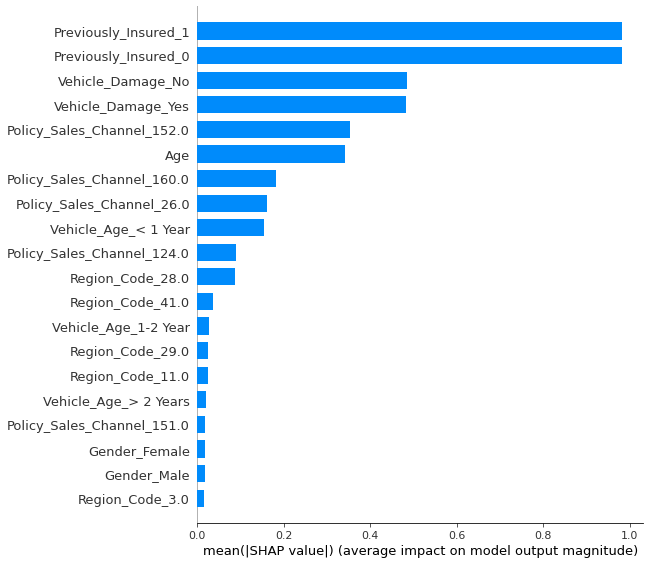

In [28]:
explainer = shap.LinearExplainer(lr_pipe[1], X_train_enc)
shap_values = explainer.shap_values(X_train_enc)
shap.initjs()
shap.summary_plot(shap_values, X_train_enc, plot_type="bar")

### Final Predictions



We will now use `predict_proba` to predict the probability of both cases where a customer is and is not interested in Vehicle Insurance. The prediction probabilities are shown in percentages so that they are more interpretable. 

In [29]:
Preds1 = [pred[1] for pred in lr_pipe.predict_proba(df_test)]
Preds0 = [pred[0] for pred in lr_pipe.predict_proba(df_test)]

response_1_predictions = pd.DataFrame(data = {'id': df_test.id, 'Response_1%': Preds1})
response_0_predictions = pd.DataFrame(data = {'id': df_test.id, 'Response_0%': Preds0})

predictions = response_1_predictions
predictions['Response_0%'] = response_0_predictions['Response_0%']
predictions = predictions.reset_index(drop=True)

predictions['Response_1%'] = 100 * predictions['Response_1%']
predictions['Response_0%'] = 100 * predictions['Response_0%']

predictions

,id,Response_1%,Response_0%
0,218826,5.853903,94.146097
1,302945,0.146484,99.853516
2,245154,0.119306,99.880694
3,257619,0.063685,99.936315
4,59339,15.919060,84.080940
...,...,...,...
95273,327245,31.243446,68.756554
95274,287068,0.038494,99.961506
95275,82687,33.138082,66.861918
95276,373801,15.418467,84.581533


<br>

We will also order the probabilities to find the customer that is most likely to be interested in Vehicle Insurance.

In [30]:
predictions.sort_values(by=['Response_1%'], ascending=False)

,id,Response_1%,Response_0%
36650,178403,58.190111,41.809889
36418,79727,57.100197,42.899803
41703,175668,56.260097,43.739903
4978,125466,55.163018,44.836982
15388,362179,54.954920,45.045080
...,...,...,...
23898,30237,0.007671,99.992329
53075,136410,0.007668,99.992332
11967,37528,0.006888,99.993112
17304,177162,0.006714,99.993286


In [31]:
(predictions['Response_1%'] >= 50.0).value_counts()

False    95198
True        80
Name: Response_1%, dtype: int64

### Conclusion

In conclusion we found that only about 80 customers in our test set had about a 50% or greater probability to be interested in Vehicle Insurance. This result should not be too surprising as the dataset is heavily unbalanced as seen in our distribution of target variable plot. This means that the majority of customers are not interested in Vehicle Insurance. But we did learn that features such as whether or not the customer was previously insured, whether or not their vehicle was damaged and the type of policy sales channel were very important in gauging the interest of a customer. 

We can trust the results we get from our model as the AUC along with the F1-score are high. Recall that AUC is the measure of seperability or how well a model is at distinguishing between values in the target class. And F1-score being a measure of a model's accuracy on the test set which is unknown data. Both AUC and F1-score are really good measures to see how our model will behave if it were put in deployment and given completely new data. 